In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy import sparse
import seaborn as sns

import time 

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Process, Pool
from itertools import repeat

import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'

### This notebook identifies the parameters of the virtual batteries and power lines in the Chicago Metropolitan area
- Conduct the simulations under different EV hosting capacity scales, charger availability levels, EV penetration levels, and spatial allocation of EV hosting capacities
- Plot the figures to illustrate their impacts

In [3]:
N_t = 96
N_n = 7
N_line = 6 # number of power lines, each line starts from node 0 and ends at node k

L = np.zeros((N_t, N_t))
for i in range(N_t):
    for j in range(N_t):
        if i >= j:
            L[i, j] = 1

In [4]:
ell_profile_init = cp.Variable((N_n, N_t))
E_profile_init = cp.Variable((N_n, N_t))
ell_UB_init = cp.Parameter((N_n, N_t))
E_UB_init = cp.Parameter((N_n, N_t))
E_LB_init = cp.Parameter((N_n, N_t))

c_init = [
    ell_profile_init >= 0,
    ell_profile_init <= ell_UB_init,
    E_profile_init >= E_LB_init,
    E_profile_init <= E_UB_init,
]

for n in range(N_n):
    c_init += [
        L @ ell_profile_init[n, :] * 0.25 == E_profile_init[n, :],
    ]

obj_init_min = cp.Minimize(cp.sum(ell_profile_init))
prob_init_min = cp.Problem(obj_init_min, c_init)

obj_init_max = cp.Maximize(cp.sum(ell_profile_init))
prob_init_max = cp.Problem(obj_init_max, c_init)


def initialProfile(ell_UB_init_value, E_UB_init_value, E_LB_init_value):
    ell_UB_init.value = ell_UB_init_value
    E_UB_init.value = E_UB_init_value
    E_LB_init.value = E_LB_init_value
    prob_init_min.solve(
        solver=cp.GUROBI,
        # verbose = True,
        warm_start = True,
        # MIPGap = 0.01
        )
    ell_init_min = ell_profile_init.value
    prob_init_max.solve(
        solver=cp.GUROBI,
        # verbose = True,
        warm_start = True,
        # MIPGap = 0.01
        )
    ell_init_max = ell_profile_init.value
    ell_nominal_matrix = (ell_init_min + ell_init_max) / 2
    # ell_nominal_matrix = ell_init_min

    E_nominal_matrix = np.zeros((N_n, N_t))
    for n in range(N_n):
        E_nominal_matrix[n] = L @ ell_nominal_matrix[n] * 0.25

    return ell_nominal_matrix, E_nominal_matrix

In [5]:
def VirtualBattey(ell_nominal_matrix, E_nominal_matrix, ell_UB_value, E_UB_value, E_LB_value):
    u_UB = np.zeros((N_n, N_t))
    u_LB = np.zeros((N_n, N_t))
    E_UB_battery = np.zeros((N_n, N_t))
    E_LB_battery = np.zeros((N_n, N_t))

    for n in range(N_n):
        u_UB[n] = (ell_UB_value[n] - ell_nominal_matrix[n])
        u_LB[n] = (0 - ell_nominal_matrix[n])
        E_UB_battery[n] = (E_UB_value[n] - E_nominal_matrix[n])
        E_LB_battery[n] = (E_LB_value[n] - E_nominal_matrix[n])

    return u_UB, u_LB, E_UB_battery, E_LB_battery
    

In [6]:
f_UB = cp.Variable((N_line, N_t))
f_LB = cp.Variable((N_line, N_t))

ell_UB_county = cp.Parameter((N_n, N_t))
E_UB_county = cp.Parameter((N_n, N_t))
E_LB_county = cp.Parameter((N_n, N_t))

ell_nominal = cp.Parameter((N_n, N_t))
E_nominal = cp.Parameter((N_n, N_t))


""" Constraints from definitions """
c_line = [
    f_UB >= f_LB,
]


"""Constraints for Cook County"""
c_line += [
    -cp.sum(f_LB, axis = 0) + ell_nominal[0] <= ell_UB_county[0],
    -cp.sum(f_UB, axis = 0) + ell_nominal[0] >= 0,
    0.25 * L @ (-cp.sum(f_LB, axis = 0) + ell_nominal[0]) <= E_UB_county[0],
    0.25 * L @ (-cp.sum(f_UB, axis = 0) + ell_nominal[0]) >= E_LB_county[0],
]

"""Constraints for Other County"""
for n in range(1, N_n):
    k = n - 1 # line index
    c_line += [
        f_UB[k] + ell_nominal[n] <= ell_UB_county[n],
        f_LB[k] + ell_nominal[n] >= 0,
        0.25 * L @ (f_UB[k] + ell_nominal[n]) <= E_UB_county[n],
        0.25 * L @ (f_LB[k] + ell_nominal[n]) >= E_LB_county[n],
    ]

# obj_line = cp.Maximize(
#     cp.sum([cp.sum(f_UB[k]-f_LB[k]) - 0.1*cp.norm(f_UB[k]-f_LB[k], 2) for k in range(N_line)])
#     )

obj_line = cp.Maximize(
    cp.sum([cp.sum(f_UB[k]-f_LB[k]) - 0.1*cp.norm(f_UB[k]-cp.mean(f_UB[k]), 2) 
            - 0.1*cp.norm(f_LB[k]-cp.mean(f_LB[k]), 2) for k in range(N_line)])
    )

prob_line = cp.Problem(obj_line, c_line)

def VirtualLine(ell_nominal_matrix, E_nominal_matrix, ell_UB_value, E_UB_value, E_LB_value):
    ell_nominal.value = ell_nominal_matrix
    E_nominal.value = E_nominal_matrix
    ell_UB_county.value = ell_UB_value
    E_UB_county.value = E_UB_value
    E_LB_county.value = E_LB_value

    prob_line.solve(
        solver=cp.GUROBI,
        # verbose = True,
        warm_start = True,
        # MIPGap = 0.01
        )

    f_UB_value = f_UB.value
    f_LB_value = f_LB.value

    return f_UB_value, f_LB_value

In [28]:
"""results for the base case in Section 3"""

# load real EV hosting capacity
capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000

"""parameters for the base case in Section 3"""
peneList = [0.05]
ratio_pubCharger_list = [0.4]
capacity_scale = [1] # different EV hosting capacity
peneNum = 1
capacityNum = 1
ratioNum = 1

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

ell_UB_rec = {}

for i in range(peneNum):
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/AggregateModel_realPene/pene={pene_value:.3f}'
    for ratio_pubCharger in ratio_pubCharger_list:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(capacityNum):
            ell_UB_temp = sparse.load_npz(f"{path_temp}/ell_UB_new_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()[0]
            ell_UB_rec[i] = ell_UB_temp
            E_UB_temp = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()[0]
            E_LB_temp = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()[0]
            ell_UB_temp = ell_UB_temp.reshape(N_n, N_t)
            E_UB_temp = E_UB_temp.reshape(N_n, N_t)
            E_LB_temp = E_LB_temp.reshape(N_n, N_t)

            """get the initial charging power profile"""
            ell_nominal_temp, E_nominal_temp = initialProfile(ell_UB_temp, E_UB_temp, E_LB_temp)

            """get the parameters of virtual batteries"""
            u_UB_temp, u_LB_temp, E_UB_battery_temp, E_LB_battery_temp = VirtualBattey(
                ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            u_UB_rec[i][ratio_pubCharger][j] = u_UB_temp
            u_LB_rec[i][ratio_pubCharger][j] = u_LB_temp
            E_UB_rec[i][ratio_pubCharger][j] = E_UB_battery_temp
            E_LB_rec[i][ratio_pubCharger][j] = E_LB_battery_temp


            """get the parameters of virtual lines"""
            f_UB_temp, f_LB_temp = VirtualLine(ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            f_UB_rec[i][ratio_pubCharger][j] = f_UB_temp
            f_LB_rec[i][ratio_pubCharger][j] = f_LB_temp

            print (f"pene={pene_value:.3f}, ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}")

            break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value



import os
filePath = 'Results/Chicago2017_RealCapacity/VB_VL_realPene'
   
for i in [0]:
    for ratio_pubCharger in ratio_pubCharger_list:
        pene_value = float(peneList[i])
        path_temp = filePath + f'/pene={pene_value:.3f}'
        isExists=os.path.exists(path_temp) #判断路径是否存在，存在则返回true
        if not isExists:
            os.makedirs(path_temp)
           
        for j in range(capacityNum):

            """save the charging power profiles"""
            u_UB_sparse = sparse.csr_matrix(u_UB_rec[i][ratio_pubCharger][j])
            u_LB_sparse = sparse.csr_matrix(u_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", u_UB_sparse)
            sparse.save_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", u_LB_sparse)
            """save the energy bounds"""
            E_UB_sparse = sparse.csr_matrix(E_UB_rec[i][ratio_pubCharger][j])
            E_LB_sparse = sparse.csr_matrix(E_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", E_UB_sparse)
            sparse.save_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", E_LB_sparse)

            """save the power flow profiles"""
            f_UB_sparse = sparse.csr_matrix(f_UB_rec[i][ratio_pubCharger][j])
            f_LB_sparse = sparse.csr_matrix(f_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", f_UB_sparse)
            sparse.save_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz", f_LB_sparse)
            print (f"ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}, pene={peneList[i]}, saved")
            break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value

            
            

pene=0.050, ratio=0.4, scale=1
ratio=0.4, scale=1, pene=0.05, saved


In [ ]:
"""results for the base case in Section 4 (different EV hosting capacity, Figs 6(a)-(c))"""

# load real EV hosting capacity
capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000


peneNum = 10
capacityNum = 11
capacity_scale = np.arange(capacityNum)*0.5 + 1 # different EV hosting capacity
peneList = np.linspace(0.1, 1, peneNum) # different EV penetration rate
ratio_pubCharger_list = np.linspace(0.1, 1, 10) # different availability level of public chargers
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

ell_UB_rec = {}

for i in range(4, peneNum):
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/AggregateModel_pubCharger/pene={pene_value:.1f}'
    for ratio_pubCharger in ratio_pubCharger_list[3:]:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(capacityNum):
            ell_UB_temp = sparse.load_npz(f"{path_temp}/ell_UB_new_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_rec[i] = ell_UB_temp
            E_UB_temp = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            E_LB_temp = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_temp = ell_UB_temp.reshape(N_n, N_t)
            E_UB_temp = E_UB_temp.reshape(N_n, N_t)
            E_LB_temp = E_LB_temp.reshape(N_n, N_t)

            """get the initial charging power profile"""
            ell_nominal_temp, E_nominal_temp = initialProfile(ell_UB_temp, E_UB_temp, E_LB_temp)

            """get the parameters of virtual batteries"""
            u_UB_temp, u_LB_temp, E_UB_battery_temp, E_LB_battery_temp = VirtualBattey(
                ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            u_UB_rec[i][ratio_pubCharger][j] = u_UB_temp
            u_LB_rec[i][ratio_pubCharger][j] = u_LB_temp
            E_UB_rec[i][ratio_pubCharger][j] = E_UB_battery_temp
            E_LB_rec[i][ratio_pubCharger][j] = E_LB_battery_temp


            """get the parameters of virtual lines"""
            f_UB_temp, f_LB_temp = VirtualLine(ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            f_UB_rec[i][ratio_pubCharger][j] = f_UB_temp
            f_LB_rec[i][ratio_pubCharger][j] = f_LB_temp

            print (f"pene={pene_value:.3f}, ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}")

            # break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value



import os
filePath = 'Results/Chicago2017_RealCapacity/VB_VL_realPene'
   
# for sessionNum in sessionNumList:
for i in [4]:
    for ratio_pubCharger in ratio_pubCharger_list[3:]:
        pene_value = float(peneList[i])
        path_temp = filePath + f'/pene={pene_value:.1f}'
        isExists=os.path.exists(path_temp) #判断路径是否存在，存在则返回true
        if not isExists:
            os.makedirs(path_temp)
           
        for j in range(capacityNum):

            """save the charging power profiles"""
            u_UB_sparse = sparse.csr_matrix(u_UB_rec[i][ratio_pubCharger][j])
            u_LB_sparse = sparse.csr_matrix(u_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_UB_sparse)
            sparse.save_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_LB_sparse)
            """save the energy bounds"""
            E_UB_sparse = sparse.csr_matrix(E_UB_rec[i][ratio_pubCharger][j])
            E_LB_sparse = sparse.csr_matrix(E_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_UB_sparse)
            sparse.save_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_LB_sparse)

            """save the power flow profiles"""
            f_UB_sparse = sparse.csr_matrix(f_UB_rec[i][ratio_pubCharger][j])
            f_LB_sparse = sparse.csr_matrix(f_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_UB_sparse)
            sparse.save_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_LB_sparse)
            print (f"ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}, pene={peneList[i]}, saved")
            # break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value



"""gaps under different scales"""
E_gap = np.zeros((capacityNum, 2)) # cook county and others
u_gap = np.zeros((capacityNum, 2)) # cook county and others
f_gap = np.zeros(capacityNum) # cook county to others
for j in range(capacityNum):
    E_gap_county = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    E_gap[j, 0] = E_gap_county[0]
    E_gap[j, 1] = E_gap_county[1:].sum()

    u_gap_county = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    u_gap[j, 0] = u_gap_county[0]
    u_gap[j, 1] = u_gap_county[1:].sum()

    f_gap[j] = (f_UB_rec[i][ratio_pubCharger][j] - f_LB_rec[i][ratio_pubCharger][j]).sum(axis = 0).mean()

            

pene=0.500, ratio=0.4, scale=1.0
pene=0.500, ratio=0.4, scale=1.5
pene=0.500, ratio=0.4, scale=2.0
pene=0.500, ratio=0.4, scale=2.5
pene=0.500, ratio=0.4, scale=3.0
pene=0.500, ratio=0.4, scale=3.5
pene=0.500, ratio=0.4, scale=4.0
pene=0.500, ratio=0.4, scale=4.5
pene=0.500, ratio=0.4, scale=5.0
pene=0.500, ratio=0.4, scale=5.5
pene=0.500, ratio=0.4, scale=6.0
ratio=0.4, scale=1.0, pene=0.5, saved
ratio=0.4, scale=1.5, pene=0.5, saved
ratio=0.4, scale=2.0, pene=0.5, saved
ratio=0.4, scale=2.5, pene=0.5, saved
ratio=0.4, scale=3.0, pene=0.5, saved
ratio=0.4, scale=3.5, pene=0.5, saved
ratio=0.4, scale=4.0, pene=0.5, saved
ratio=0.4, scale=4.5, pene=0.5, saved
ratio=0.4, scale=5.0, pene=0.5, saved
ratio=0.4, scale=5.5, pene=0.5, saved
ratio=0.4, scale=6.0, pene=0.5, saved


/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

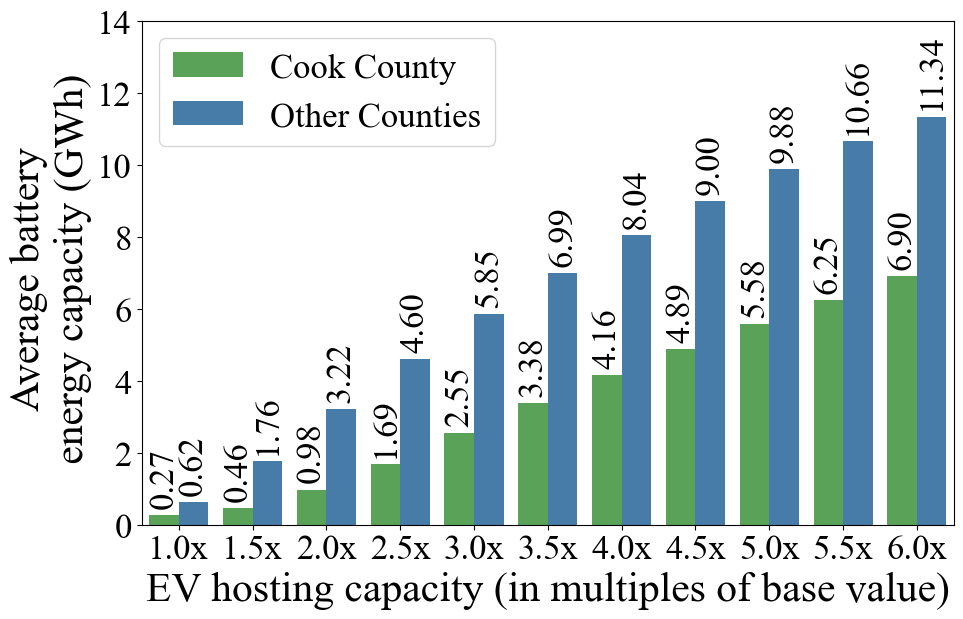

In [10]:
"""Battery energy capacity under different scales"""


import seaborn as sns

data = E_gap/1000
scale = [f'{0.5*i+1}x' for i in range(data.shape[0])]
cook_county = data[:, 0]
other_counties = data[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Scale': scale,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Scale', y='value', hue='variable', data=pd.melt(df, ['Scale']), palette=colors)

# 设置标题和标签
plt.xlabel('EV hosting capacity (in multiples of base value)', fontsize=30)
plt.ylabel('Average battery \n energy capacity (GWh)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height+0.2,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25)
ax.set_ylim(0, 14)

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_energy_capacity_scale.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

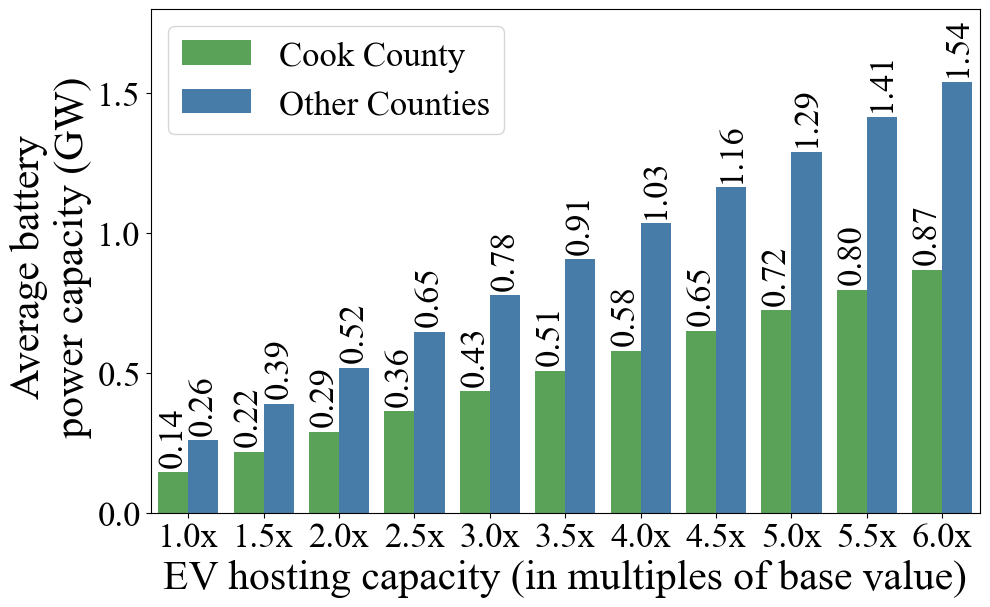

In [11]:
"""Battery power capacity under different scales"""


import seaborn as sns

data = u_gap/1000
cook_county = data[:, 0]
other_counties = data[:, 1]
scale = [f'{0.5*i+1}x' for i in range(data.shape[0])]

# 创建 DataFrame
df = pd.DataFrame({
    'Scale': scale,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Scale', y='value', hue='variable', data=pd.melt(df, ['Scale']), palette=colors)

# 设置标题和标签
plt.xlabel('EV hosting capacity (in multiples of base value)', fontsize=30)
plt.ylabel('Average battery \n power capacity (GW)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height+0.02,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25)
ax.set_ylim(0, 1.8)

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_power_capacity_scale.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


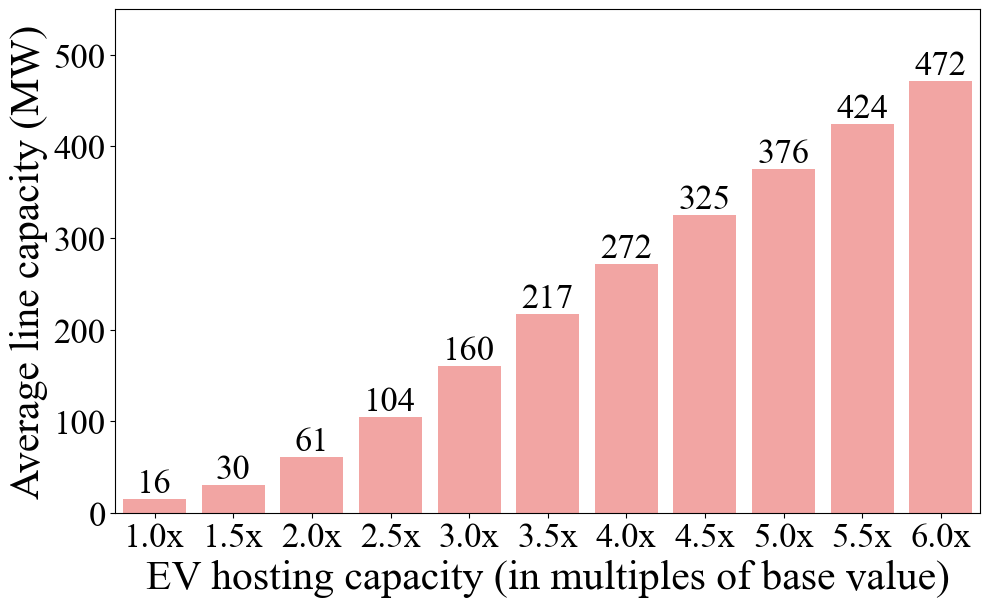

In [12]:
"""Line capacity under different scales"""
new_data = f_gap

scale = [f'{0.5*i+1}x' for i in range(data.shape[0])]

# 创建 DataFrame
df_new = pd.DataFrame({
    'Scale': scale,
    'New Data': new_data
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 自定义颜色
color = '#ff9896'  # 选择一种新的适合 Nature Energy 风格的颜色

# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Scale', y='New Data', data=df_new, color=color)

# 设置标题和标签
plt.xlabel('EV hosting capacity (in multiples of base value)', fontsize=30)
plt.ylabel('Average line capacity (MW)', fontsize=30)
# plt.title('New Data by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.0f}'.format(height),
            ha='center', va='bottom', fontsize=25)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
# ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])

# 保存图表
ax.set_ylim(0, 550)
# plt.savefig('figures/Chicago2017_RealCapacity/avg_line_capacity_scale.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [ ]:
"""results for the base case in Section 4 (different public charger availability, Figs 6(g)-(i))"""

# load real EV hosting capacity
capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000


peneNum = 10
capacityNum = 11
capacity_scale = np.arange(capacityNum)*0.5 + 1 # different EV hosting capacity
peneList = np.linspace(0.1, 1, peneNum) # different EV penetration rate
ratio_pubCharger_list = np.linspace(0.1, 1, 10) # different availability level of public chargers
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

ell_UB_rec = {}

for i in range(4, peneNum):
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/AggregateModel_pubCharger/pene={pene_value:.1f}'
    for ratio_pubCharger in ratio_pubCharger_list:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(10, capacityNum):
            ell_UB_temp = sparse.load_npz(f"{path_temp}/ell_UB_new_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_rec[i] = ell_UB_temp
            E_UB_temp = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            E_LB_temp = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_temp = ell_UB_temp.reshape(N_n, N_t)
            E_UB_temp = E_UB_temp.reshape(N_n, N_t)
            E_LB_temp = E_LB_temp.reshape(N_n, N_t)

            """get the initial charging power profile"""
            ell_nominal_temp, E_nominal_temp = initialProfile(ell_UB_temp, E_UB_temp, E_LB_temp)

            """get the parameters of virtual batteries"""
            u_UB_temp, u_LB_temp, E_UB_battery_temp, E_LB_battery_temp = VirtualBattey(
                ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            u_UB_rec[i][ratio_pubCharger][j] = u_UB_temp
            u_LB_rec[i][ratio_pubCharger][j] = u_LB_temp
            E_UB_rec[i][ratio_pubCharger][j] = E_UB_battery_temp
            E_LB_rec[i][ratio_pubCharger][j] = E_LB_battery_temp


            """get the parameters of virtual lines"""
            f_UB_temp, f_LB_temp = VirtualLine(ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            f_UB_rec[i][ratio_pubCharger][j] = f_UB_temp
            f_LB_rec[i][ratio_pubCharger][j] = f_LB_temp

            print (f"pene={pene_value:.3f}, ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}")

            break # only one capacity scale
        # break # only one ratio_pubCharger
    break # only one pene_value



import os
filePath = 'Results/Chicago2017_RealCapacity/VB_VL_realPene'
   
# for sessionNum in sessionNumList:
for i in [4]:
    for ratio_pubCharger in ratio_pubCharger_list:
        pene_value = float(peneList[i])
        path_temp = filePath + f'/pene={pene_value:.1f}'
        isExists=os.path.exists(path_temp) #判断路径是否存在，存在则返回true
        if not isExists:
            os.makedirs(path_temp)
           
        for j in range(10, capacityNum):

            """save the charging power profiles"""
            u_UB_sparse = sparse.csr_matrix(u_UB_rec[i][ratio_pubCharger][j])
            u_LB_sparse = sparse.csr_matrix(u_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_UB_sparse)
            sparse.save_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_LB_sparse)
            """save the energy bounds"""
            E_UB_sparse = sparse.csr_matrix(E_UB_rec[i][ratio_pubCharger][j])
            E_LB_sparse = sparse.csr_matrix(E_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_UB_sparse)
            sparse.save_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_LB_sparse)

            """save the power flow profiles"""
            f_UB_sparse = sparse.csr_matrix(f_UB_rec[i][ratio_pubCharger][j])
            f_LB_sparse = sparse.csr_matrix(f_LB_rec[i][ratio_pubCharger][j])
            sparse.save_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_UB_sparse)
            sparse.save_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_LB_sparse)
            print (f"ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}, pene={peneList[i]}, saved")
            break # only one capacity scale
        # break # only one ratio_pubCharger
    break # only one pene_value



"""gaps under different ratios"""
E_gap = np.zeros((ratioNum, 2)) # cook county and others
u_gap = np.zeros((ratioNum, 2)) # cook county and others
f_gap = np.zeros(ratioNum) # cook county to others
for r in range(ratioNum):
    ratio_pubCharger = ratio_pubCharger_list[r]
    E_gap_county = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    E_gap[r, 0] = E_gap_county[0]
    E_gap[r, 1] = E_gap_county[1:].sum()

    u_gap_county = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    u_gap[r, 0] = u_gap_county[0]
    u_gap[r, 1] = u_gap_county[1:].sum()

    f_gap[r] = (f_UB_rec[i][ratio_pubCharger][j] - f_LB_rec[i][ratio_pubCharger][j]).sum(axis = 0).mean()

            

pene=0.500, ratio=0.1, scale=6.0
pene=0.500, ratio=0.2, scale=6.0
pene=0.500, ratio=0.3, scale=6.0
pene=0.500, ratio=0.4, scale=6.0
pene=0.500, ratio=0.5, scale=6.0
pene=0.500, ratio=0.6, scale=6.0
pene=0.500, ratio=0.7, scale=6.0
pene=0.500, ratio=0.8, scale=6.0
pene=0.500, ratio=0.9, scale=6.0
pene=0.500, ratio=1.0, scale=6.0
ratio=0.1, scale=6.0, pene=0.5, saved
ratio=0.2, scale=6.0, pene=0.5, saved
ratio=0.3, scale=6.0, pene=0.5, saved
ratio=0.4, scale=6.0, pene=0.5, saved
ratio=0.5, scale=6.0, pene=0.5, saved
ratio=0.6, scale=6.0, pene=0.5, saved
ratio=0.7, scale=6.0, pene=0.5, saved
ratio=0.8, scale=6.0, pene=0.5, saved
ratio=0.9, scale=6.0, pene=0.5, saved
ratio=1.0, scale=6.0, pene=0.5, saved


/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

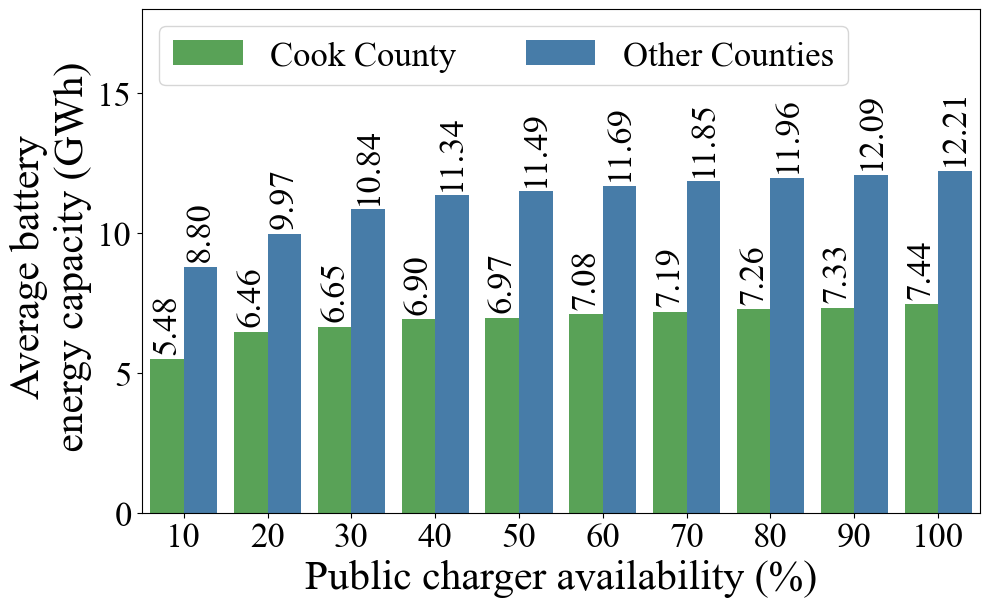

In [20]:
"""Battery energy capacity under different ratios"""


import seaborn as sns

data = E_gap/1000
cook_county = data[:, 0]
other_counties = data[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Ratio': ratio_pubCharger_list,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Ratio', y='value', hue='variable', data=pd.melt(df, ['Ratio']), palette=colors)

# 设置标题和标签
plt.xlabel('Public charger availability (%)', fontsize=30)
plt.ylabel('Average battery \n energy capacity (GWh)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])


ax.set_ylim(0, 18)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25, ncol=2, loc='upper left')

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_energy_capacity_ratio.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

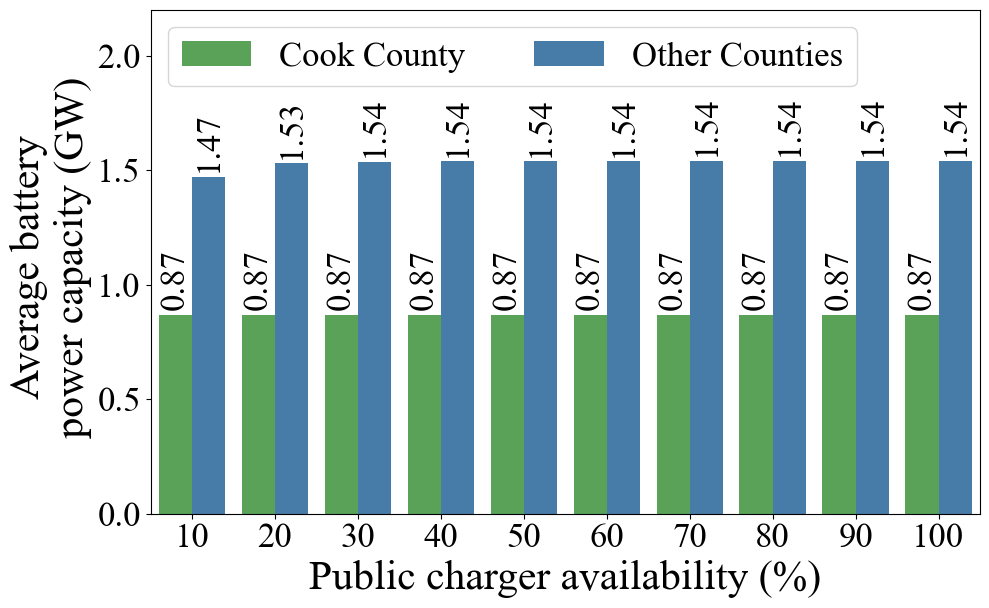

In [21]:
"""Battery energy capacity under different ratios"""


import seaborn as sns

data = u_gap/1000
scale = [f'{i+1}x' for i in range(data.shape[0])]
cook_county = data[:, 0]
other_counties = data[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Ratio': ratio_pubCharger_list,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Ratio', y='value', hue='variable', data=pd.melt(df, ['Ratio']), palette=colors)

# 设置标题和标签
plt.xlabel('Public charger availability (%)', fontsize=30)
plt.ylabel('Average battery \n power capacity (GW)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.02,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])


ax.set_ylim(0, 2.2)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25, ncol=2, loc='upper left')

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_power_capacity_ratio.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


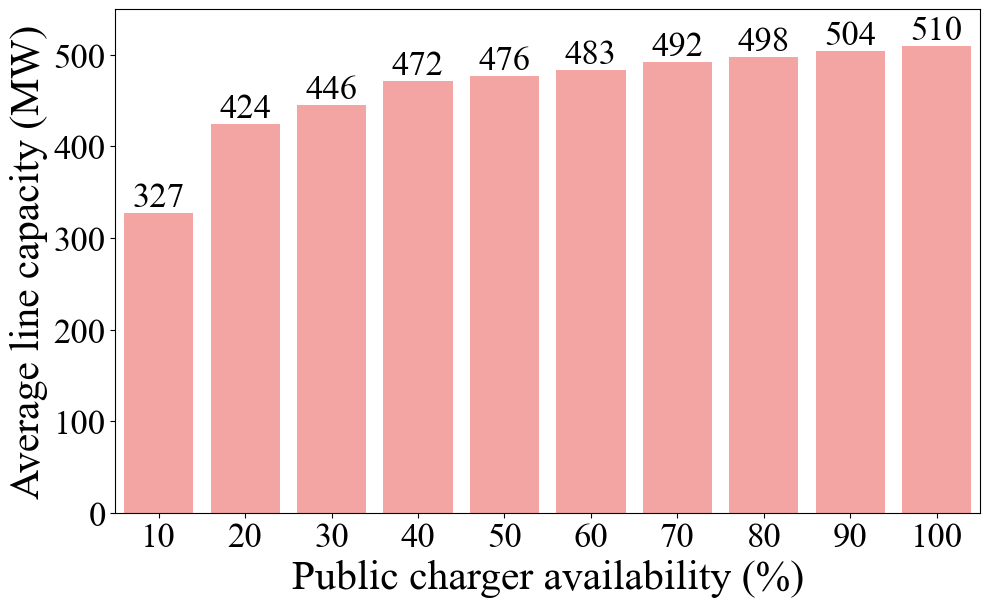

In [22]:
"""Line capacity under different scales"""
new_data = f_gap

scale = [f'{i+1}x' for i in range(len(new_data))]

# 创建 DataFrame
df_new = pd.DataFrame({
    'Ratio': ratio_pubCharger_list,
    'New Data': new_data
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 自定义颜色
color = '#ff9896'  # 选择一种新的适合 Nature Energy 风格的颜色

# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Ratio', y='New Data', data=df_new, color=color)

# 设置标题和标签
plt.xlabel('Public charger availability (%)', fontsize=30)
plt.ylabel('Average line capacity (MW)', fontsize=30)
# plt.title('New Data by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.0f}'.format(height),
            ha='center', va='bottom', fontsize=25)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])

# 保存图表
ax.set_ylim(0, 550)
# plt.savefig('figures/Chicago2017_RealCapacity/avg_line_capacity_ratio.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [ ]:
"""results for the base case in Section 5 (different EV penetration, Figs 7(d)-(f))"""

# load real EV hosting capacity
capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000


peneNum = 10
capacityNum = 11
capacity_scale = np.arange(capacityNum)*0.5 + 1 # different EV hosting capacity
peneList = np.linspace(0.1, 1, peneNum) # different EV penetration rate
ratio_pubCharger_list = np.linspace(0.1, 1, 10) # different availability level of public chargers
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

ell_UB_rec = {}

for i in range(peneNum):
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/AggregateModel_pubCharger/pene={pene_value:.1f}'
    for ratio_pubCharger in ratio_pubCharger_list[3:]:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(10, capacityNum):
            ell_UB_temp = sparse.load_npz(f"{path_temp}/ell_UB_new_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_rec[i] = ell_UB_temp
            E_UB_temp = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            E_LB_temp = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz").toarray()[0]
            ell_UB_temp = ell_UB_temp.reshape(N_n, N_t)
            E_UB_temp = E_UB_temp.reshape(N_n, N_t)
            E_LB_temp = E_LB_temp.reshape(N_n, N_t)

            """get the initial charging power profile"""
            ell_nominal_temp, E_nominal_temp = initialProfile(ell_UB_temp, E_UB_temp, E_LB_temp)

            """get the parameters of virtual batteries"""
            u_UB_temp, u_LB_temp, E_UB_battery_temp, E_LB_battery_temp = VirtualBattey(
                ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            u_UB_rec[i][ratio_pubCharger][j] = u_UB_temp
            u_LB_rec[i][ratio_pubCharger][j] = u_LB_temp
            E_UB_rec[i][ratio_pubCharger][j] = E_UB_battery_temp
            E_LB_rec[i][ratio_pubCharger][j] = E_LB_battery_temp


            """get the parameters of virtual lines"""
            f_UB_temp, f_LB_temp = VirtualLine(ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            f_UB_rec[i][ratio_pubCharger][j] = f_UB_temp
            f_LB_rec[i][ratio_pubCharger][j] = f_LB_temp

            print (f"pene={pene_value:.3f}, ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}")

            break # only one capacity scale
        break # only one ratio_pubCharger
    # break # only one pene_value



import os
filePath = 'Results/Chicago2017_RealCapacity/VB_VL_realPene'
   
for i in range(peneNum):
    for ratio_pubCharger in ratio_pubCharger_list[3:]:
        pene_value = float(peneList[i])
        path_temp = filePath + f'/pene={pene_value:.1f}'
        isExists=os.path.exists(path_temp) #判断路径是否存在，存在则返回true
        if not isExists:
            os.makedirs(path_temp)
           
        for j in range(10, capacityNum):

            # """save the charging power profiles"""
            # u_UB_sparse = sparse.csr_matrix(u_UB_rec[i][ratio_pubCharger][j])
            # u_LB_sparse = sparse.csr_matrix(u_LB_rec[i][ratio_pubCharger][j])
            # sparse.save_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_UB_sparse)
            # sparse.save_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", u_LB_sparse)
            # """save the energy bounds"""
            # E_UB_sparse = sparse.csr_matrix(E_UB_rec[i][ratio_pubCharger][j])
            # E_LB_sparse = sparse.csr_matrix(E_LB_rec[i][ratio_pubCharger][j])
            # sparse.save_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_UB_sparse)
            # sparse.save_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", E_LB_sparse)

            # """save the power flow profiles"""
            # f_UB_sparse = sparse.csr_matrix(f_UB_rec[i][ratio_pubCharger][j])
            # f_LB_sparse = sparse.csr_matrix(f_LB_rec[i][ratio_pubCharger][j])
            # sparse.save_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_UB_sparse)
            # sparse.save_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]}.npz", f_LB_sparse)
            print (f"ratio={ratio_pubCharger:.1f}, scale={capacity_scale[j]}, pene={peneList[i]}, saved")
            break # only one capacity scale
        break # only one ratio_pubCharger
    # break # only one pene_value



"""gaps under different pene"""
E_gap = np.zeros((peneNum, 2)) # cook county and others
u_gap = np.zeros((peneNum, 2)) # cook county and others
f_gap = np.zeros(peneNum) # cook county to others
for i in range(peneNum):
    pene_value = peneList[i]
    E_gap_county = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    E_gap[i, 0] = E_gap_county[0]
    E_gap[i, 1] = E_gap_county[1:].sum()

    u_gap_county = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)
    u_gap[i, 0] = u_gap_county[0]
    u_gap[i, 1] = u_gap_county[1:].sum()

    f_gap[i] = (f_UB_rec[i][ratio_pubCharger][j] - f_LB_rec[i][ratio_pubCharger][j]).sum(axis = 0).mean()

            

pene=0.100, ratio=0.4, scale=6.0
pene=0.200, ratio=0.4, scale=6.0
pene=0.300, ratio=0.4, scale=6.0
pene=0.400, ratio=0.4, scale=6.0
pene=0.500, ratio=0.4, scale=6.0
pene=0.600, ratio=0.4, scale=6.0
pene=0.700, ratio=0.4, scale=6.0
pene=0.800, ratio=0.4, scale=6.0
pene=0.900, ratio=0.4, scale=6.0
pene=1.000, ratio=0.4, scale=6.0
ratio=0.4, scale=6.0, pene=0.1, saved
ratio=0.4, scale=6.0, pene=0.2, saved
ratio=0.4, scale=6.0, pene=0.30000000000000004, saved
ratio=0.4, scale=6.0, pene=0.4, saved
ratio=0.4, scale=6.0, pene=0.5, saved
ratio=0.4, scale=6.0, pene=0.6, saved
ratio=0.4, scale=6.0, pene=0.7000000000000001, saved
ratio=0.4, scale=6.0, pene=0.8, saved
ratio=0.4, scale=6.0, pene=0.9, saved
ratio=0.4, scale=6.0, pene=1.0, saved


/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

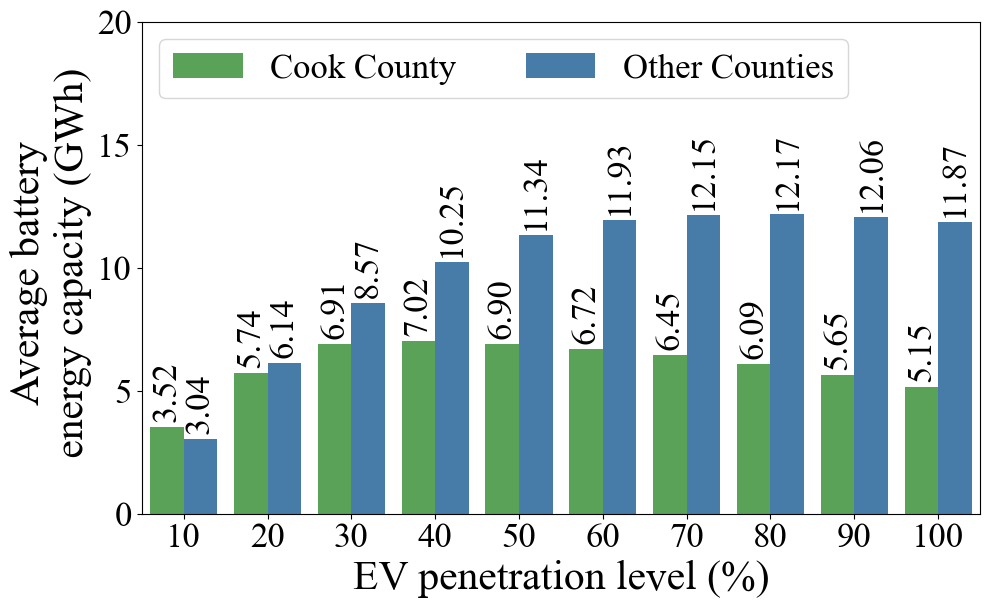

In [24]:
"""Battery energy capacity under different pene"""


import seaborn as sns

data = E_gap/1000
scale = [f'{i+1}x' for i in range(data.shape[0])]
cook_county = data[:, 0]
other_counties = data[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Pene': peneList,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Pene', y='value', hue='variable', data=pd.melt(df, ['Pene']), palette=colors)

# 设置标题和标签
plt.xlabel('EV penetration level (%)', fontsize=30)
plt.ylabel('Average battery \n energy capacity (GWh)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])


ax.set_ylim(0, 20)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25, loc='upper left', ncol=2)

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_energy_capacity_pene.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

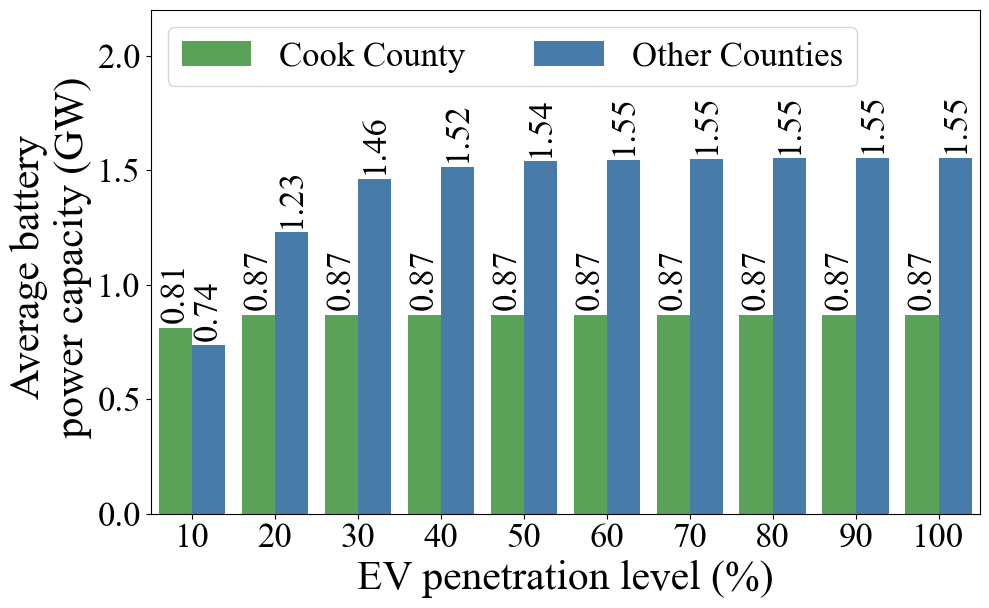

In [25]:
"""Battery energy capacity under different ratios"""


import seaborn as sns

data = u_gap/1000
# scale = [f'{i+1}x' for i in range(data.shape[0])]
cook_county = data[:, 0]
other_counties = data[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Pene': peneList,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

colors = ['#4daf4a', '#377eb8']
# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Pene', y='value', hue='variable', data=pd.melt(df, ['Pene']), palette=colors)

# 设置标题和标签
plt.xlabel('EV penetration level (%)', fontsize=30)
plt.ylabel('Average battery \n power capacity (GW)', fontsize=30)
# plt.title('Avg. Battery Energy Capacity by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.02,
            '{:.2f}'.format(height),
            ha='center', va='bottom', fontsize=25, rotation=90)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])


ax.set_ylim(0, 2.2)

# 添加图例标题
legend_title = "County"
plt.legend(fontsize=25, loc='upper left', ncol=2)

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_power_capacity_pene.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


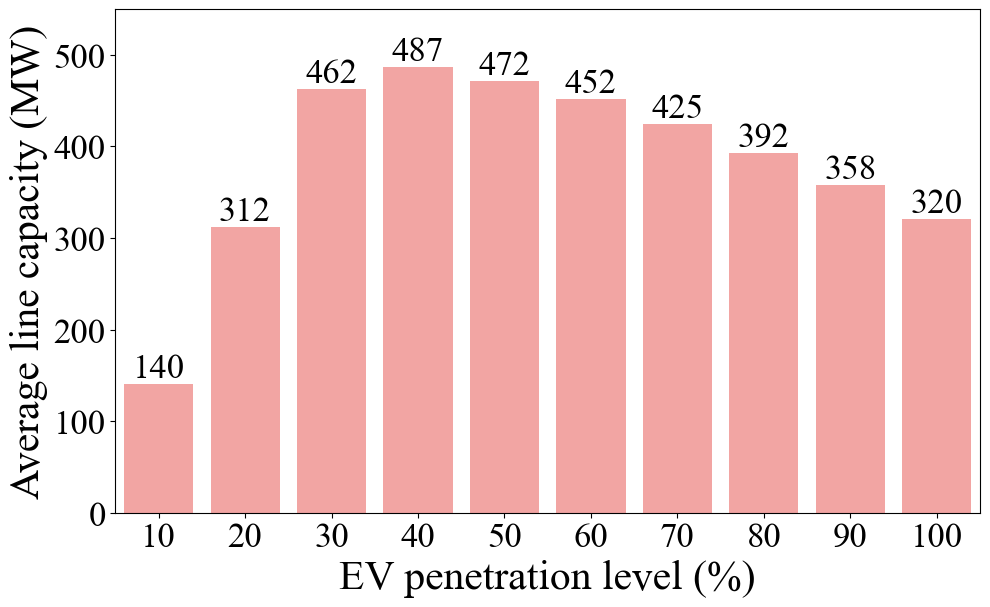

In [26]:
"""Line capacity under different pene"""
new_data = f_gap

scale = [f'{i+1}x' for i in range(len(new_data))]

# 创建 DataFrame
df_new = pd.DataFrame({
    'Pene': peneList,
    'New Data': new_data
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 自定义颜色
color = '#ff9896'  # 选择一种新的适合 Nature Energy 风格的颜色

# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Pene', y='New Data', data=df_new, color=color)

# 设置标题和标签
plt.xlabel('EV penetration level (%)', fontsize=30)
plt.ylabel('Average line capacity (MW)', fontsize=30)
# plt.title('New Data by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.0f}'.format(height),
            ha='center', va='bottom', fontsize=25)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])
ax.set_ylim(0, 550)
# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_line_capacity_pene.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [28]:
"""results for the base case in Section 4 (different spatial allocation Figs 6(d)-(f))"""

scale = 6
capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000
capacity_total = capacity_county.sum() * scale
peneNum = 10

proportionNum = 9
proportion_cook = np.linspace(0.1, 0.9, proportionNum)
share_restCounties = capacity_county[1:]/capacity_county[1:].sum()

capacity_distribution = np.zeros((proportionNum, N_n))
for p in range(proportionNum):
    capacity_distribution[p, 0] = capacity_total * proportion_cook[p]
    capacity_distribution[p, 1:] = capacity_total * share_restCounties * (1 - proportion_cook[p])

peneList = np.linspace(0.1, 1, peneNum)


ratio_pubCharger_list = np.linspace(0.1, 1, 10)
ratioNum = len(ratio_pubCharger_list)


u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

for i in range(4, peneNum):
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/AggregateModel_pubCharger/spatial_pene={pene_value:.1f}'
    for ratio_pubCharger in ratio_pubCharger_list[3:]:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for p in range(proportionNum):
            ell_UB_temp = sparse.load_npz(f"{path_temp}/ell_UB_new_ratio={ratio_pubCharger:.1f}_proportion_cook={proportion_cook[p]:.1f}.npz").toarray()[0]
            E_UB_temp = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_proportion_cook={proportion_cook[p]:.1f}.npz").toarray()[0]
            E_LB_temp = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_proportion_cook={proportion_cook[p]:.1f}.npz").toarray()[0]
            ell_UB_temp = ell_UB_temp.reshape(N_n, N_t)
            E_UB_temp = E_UB_temp.reshape(N_n, N_t)
            E_LB_temp = E_LB_temp.reshape(N_n, N_t)

            """get the initial charging power profile"""
            ell_nominal_temp, E_nominal_temp = initialProfile(ell_UB_temp, E_UB_temp, E_LB_temp)

            """get the parameters of virtual batteries"""
            u_UB_temp, u_LB_temp, E_UB_battery_temp, E_LB_battery_temp = VirtualBattey(
                ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            u_UB_rec[i][ratio_pubCharger][p] = u_UB_temp
            u_LB_rec[i][ratio_pubCharger][p] = u_LB_temp
            E_UB_rec[i][ratio_pubCharger][p] = E_UB_battery_temp
            E_LB_rec[i][ratio_pubCharger][p] = E_LB_battery_temp


            """get the parameters of virtual lines"""
            f_UB_temp, f_LB_temp = VirtualLine(ell_nominal_temp, E_nominal_temp, ell_UB_temp, E_UB_temp, E_LB_temp)
            f_UB_rec[i][ratio_pubCharger][p] = f_UB_temp
            f_LB_rec[i][ratio_pubCharger][p] = f_LB_temp

            # break # only one spatial distribution
        break # only one ratio_pubCharger
    break # only one pene_value


"""gaps under different pene"""
E_gap = np.zeros((proportionNum, 2)) # cook county and others
u_gap = np.zeros((proportionNum, 2)) # cook county and others
f_gap = np.zeros(proportionNum) # cook county to others
i = 4
ratio_pubCharger = 0.4
for p in range(proportionNum):
    E_gap_county = (E_UB_rec[i][ratio_pubCharger][p] - E_LB_rec[i][ratio_pubCharger][p]).mean(axis = 1)
    E_gap[p, 0] = E_gap_county[0]
    E_gap[p, 1] = E_gap_county[1:].sum()

    u_gap_county = (u_UB_rec[i][ratio_pubCharger][p] - u_LB_rec[i][ratio_pubCharger][p]).mean(axis = 1)
    u_gap[p, 0] = u_gap_county[0]
    u_gap[p, 1] = u_gap_county[1:].sum()

    f_gap[p] = (f_UB_rec[i][ratio_pubCharger][p] - f_LB_rec[i][ratio_pubCharger][p]).sum(axis = 0).mean()

            
            

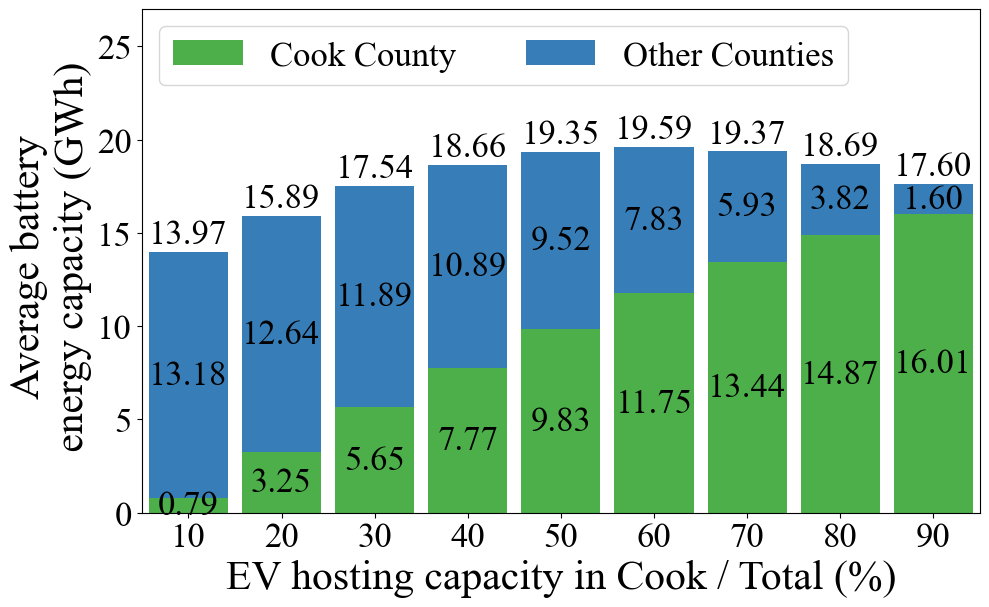

In [29]:
"""Battery energy capacity under different pene"""


import seaborn as sns

data = E_gap/1000
cook_county = data[:, 0]
other_counties = data[:, 1]

# cook_county = E_gap[:, 0]
# other_counties = E_gap[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Proportion': proportion_cook,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(10, 6.18))

# 计算柱子的宽度和位置
bar_width = 0.85
bar_positions = np.arange(len(df['Proportion']))

# 绘制 Cook County 的柱状图
bars_cook = ax.bar(bar_positions, df['Cook County'], width=bar_width, color='#4daf4a', label='Cook County')

# 绘制 Other Counties 的柱状图，堆叠在 Cook County 的柱子上
bars_other = ax.bar(bar_positions, df['Other Counties'], width=bar_width, bottom=df['Cook County'], color='#377eb8', label='Other Counties')

# 设置标题和标签
plt.xlabel('EV hosting capacity in Cook / Total (%)', fontsize=30)
plt.ylabel('Average battery \n energy capacity (GWh)', fontsize=30)

# 在每个原始的柱子中间显示数值标签
for bar in bars_cook:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height / 2,
            '{:.2f}'.format(height),
            ha='center', va='center', fontsize=25, color='black')

for bar in bars_other:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2,
            '{:.2f}'.format(height),
            ha='center', va='center', fontsize=25, color='black')

# 在堆叠后的柱子上方显示堆叠的和的标签
for bar_cook, bar_other in zip(bars_cook, bars_other):
    height_cook = bar_cook.get_height()
    height_other = bar_other.get_height()
    total = height_cook + height_other
    ax.text(bar_cook.get_x() + bar_cook.get_width() / 2., total + 0.1,
            '{:.2f}'.format(total),
            ha='center', va='bottom', fontsize=25, color='black')

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_ylim(0, 27)
ax.set_xlim(-0.5, 8.5)

# 设置 xtick 的显示精度，只显示一位小数，并确保与柱子对齐
ax.set_xticks(bar_positions)
ax.set_xticklabels([f'{p*100:.0f}' for p in df['Proportion']])

# 添加图例标题
plt.legend(fontsize=25, loc='upper left', ncol=2)

# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_energy_capacity_spatial.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

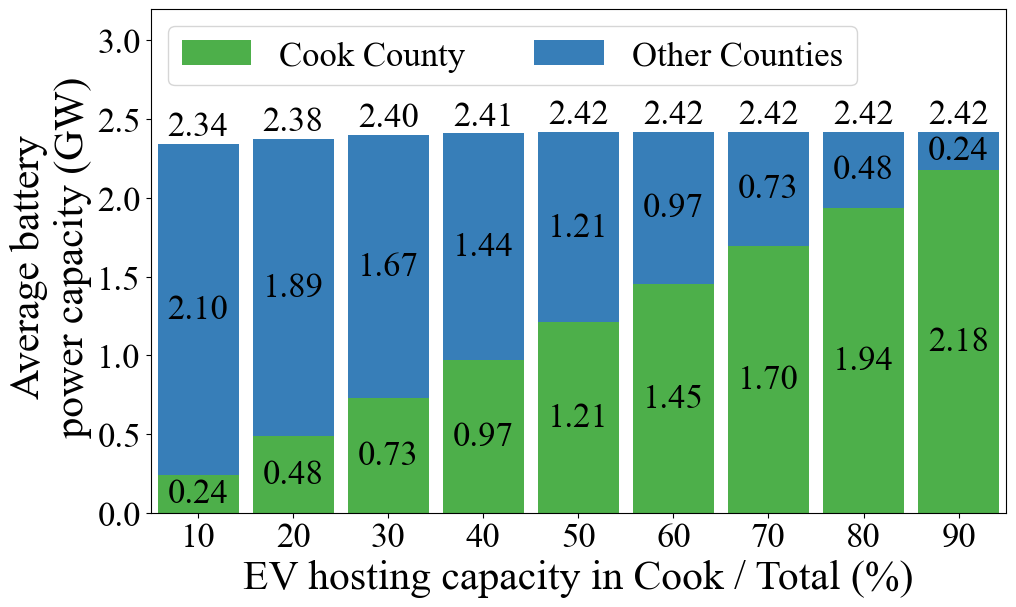

In [30]:
"""Battery energy capacity under different pene"""


import seaborn as sns

data = u_gap/1000
cook_county = data[:, 0]
other_counties = data[:, 1]

# cook_county = E_gap[:, 0]
# other_counties = E_gap[:, 1]

# 创建 DataFrame
df = pd.DataFrame({
    'Proportion': proportion_cook,
    'Cook County': cook_county,
    'Other Counties': other_counties
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(10, 6.18))

# 计算柱子的宽度和位置
bar_width = 0.85
bar_positions = np.arange(len(df['Proportion']))

# 绘制 Cook County 的柱状图
bars_cook = ax.bar(bar_positions, df['Cook County'], width=bar_width, color='#4daf4a', label='Cook County')

# 绘制 Other Counties 的柱状图，堆叠在 Cook County 的柱子上
bars_other = ax.bar(bar_positions, df['Other Counties'], width=bar_width, bottom=df['Cook County'], color='#377eb8', label='Other Counties')

# 设置标题和标签
plt.xlabel('EV hosting capacity in Cook / Total (%)', fontsize=30)
plt.ylabel('Average battery \n power capacity (GW)', fontsize=30)

# 在每个原始的柱子中间显示数值标签
for bar in bars_cook:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height / 2,
            '{:.2f}'.format(height),
            ha='center', va='center', fontsize=25, color='black')

for bar in bars_other:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2,
            '{:.2f}'.format(height),
            ha='center', va='center', fontsize=25, color='black')

# 在堆叠后的柱子上方显示堆叠的和的标签
for bar_cook, bar_other in zip(bars_cook, bars_other):
    height_cook = bar_cook.get_height()
    height_other = bar_other.get_height()
    total = height_cook + height_other
    ax.text(bar_cook.get_x() + bar_cook.get_width() / 2., total + 0.01,
            '{:.2f}'.format(total),
            ha='center', va='bottom', fontsize=25, color='black')

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_ylim(0, 3.2)
ax.set_xlim(-0.5, 8.5)

# 设置 xtick 的显示精度，只显示一位小数，并确保与柱子对齐
ax.set_xticks(bar_positions)
ax.set_xticklabels([f'{p*100:.0f}' for p in df['Proportion']])

# 添加图例标题
plt.legend(fontsize=25, ncol = 2, loc='upper left')

# plt.savefig('figures/Chicago2017_RealCapacity/avg_battery_power_capacity_spatial.pdf', format='pdf', bbox_inches='tight')
# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


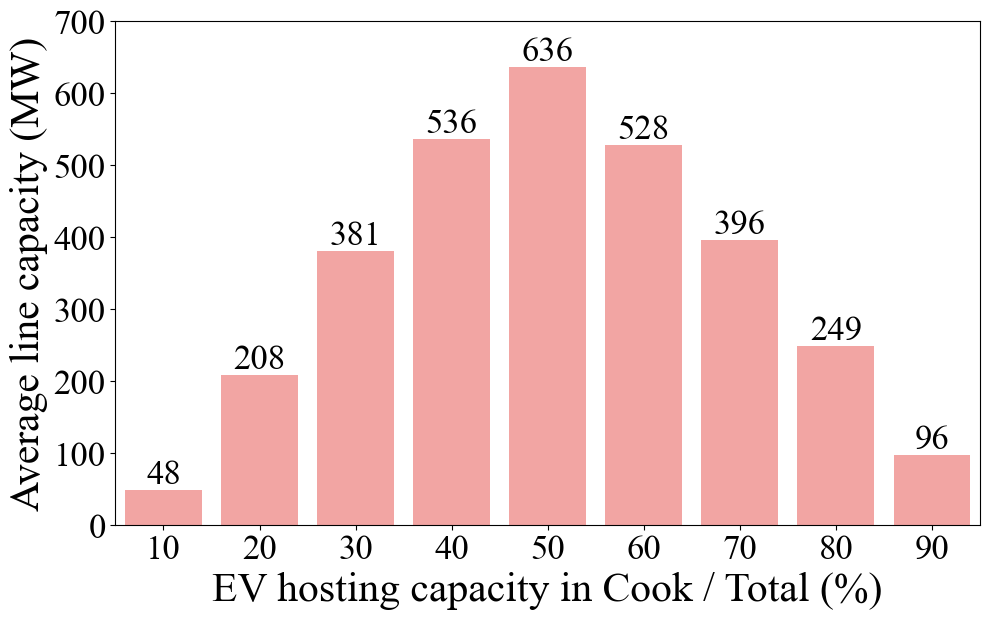

In [31]:
"""Line capacity under different pene"""
new_data = f_gap

# 创建 DataFrame
df_new = pd.DataFrame({
    'Proportion': proportion_cook,
    'New Data': new_data
})

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 自定义颜色
color = '#ff9896'  # 选择一种新的适合 Nature Energy 风格的颜色

# 绘制柱状图
plt.figure(figsize=(10, 6.18))
ax = sns.barplot(x='Proportion', y='New Data', data=df_new, color=color)

# 设置标题和标签
plt.xlabel('EV hosting capacity in Cook / Total (%)', fontsize=30)
plt.ylabel('Average line capacity (MW)', fontsize=30)
# plt.title('New Data by Scale', fontsize=20, weight='bold')

# 显示每个柱子的数值标签
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.0f}'.format(height),
            ha='center', va='bottom', fontsize=25)

# 设置 x 和 y 轴的 ticks 字体大小
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# 设置 xtick 的显示精度，只显示一位小数
ax.set_xticklabels([f'{float(label.get_text())*100:.0f}' for label in ax.get_xticklabels()])
ax.set_ylim(0, 700)
ax.set_xlim(-0.5, 8.5)

# 保存图表
# plt.savefig('figures/Chicago2017_RealCapacity/avg_line_capacity_spatial.pdf', format='pdf', bbox_inches='tight')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()